Pablo Fuentes Chemes 

Daniel Jove Díaz

# **Pretrained CNNs on CIFAR100**

In this section, we present various experiments using pretrained models (ResNet50V2 and EfficientNetB0) on the CIFAR100 dataset (coarse labels, 20 classes). Two main strategies are employed:
1. **Feature Extraction (FE)**: Freezing the base layers and training only the top layers.
2. **Fine-Tuning (FT)**: Unfreezing some of the final layers of the base to further adapt the model.



In [ ]:
import tensorflow as tf
from utils import plot_label_distribution
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import keras

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="coarse")

# Print the shape of the data
print(f'Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}')
print(f'Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}')
num_classes = len(set(y_train.flatten()))
print(f'Number of different labels: {num_classes}')

2025-03-19 15:38:06.698787: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 15:38:06.918894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742395087.014196    6384 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742395087.040400    6384 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 15:38:07.216628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 1)
Number of different labels: 20


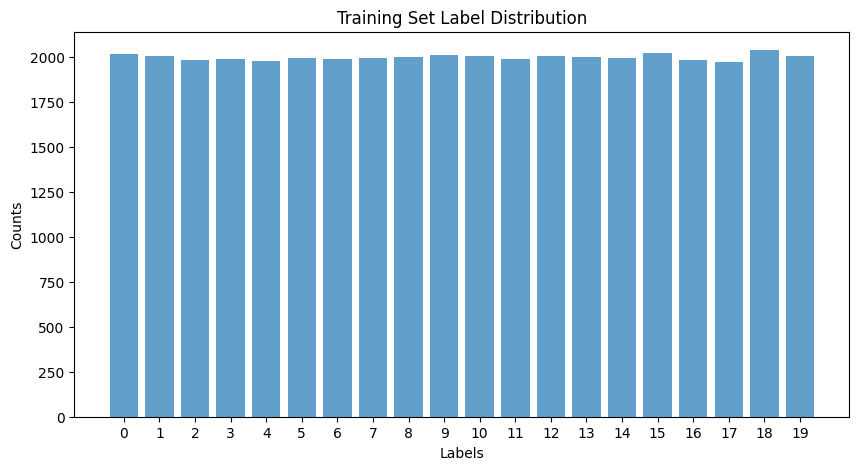

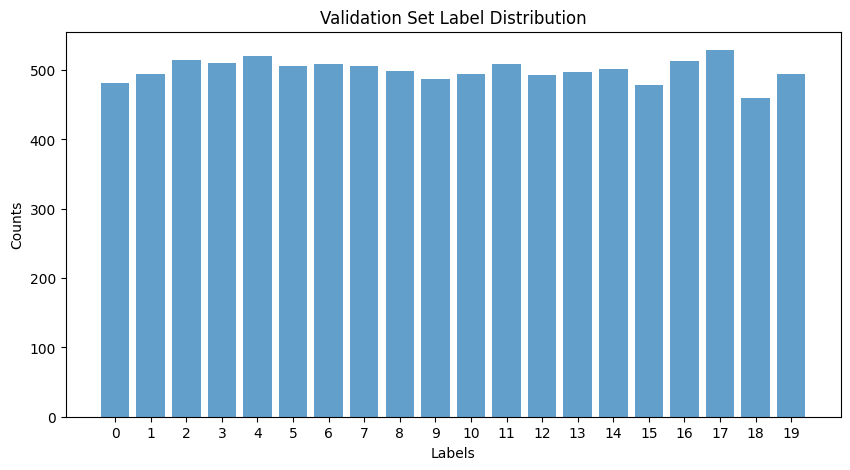

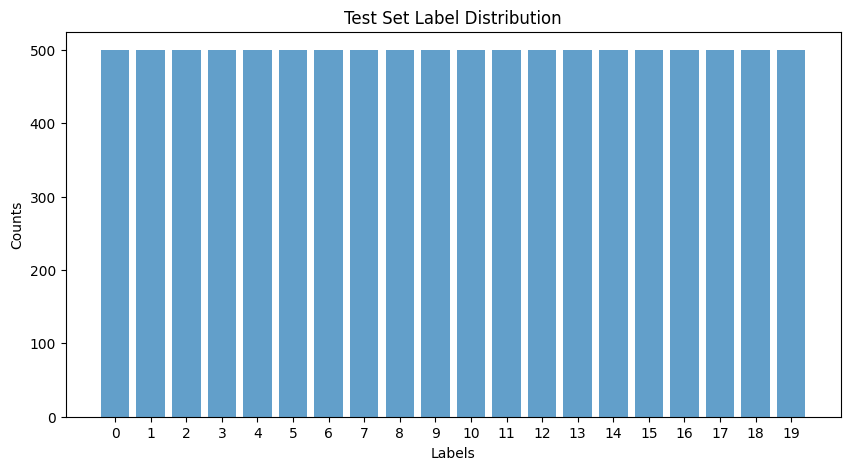

New training data shape: (40000, 32, 32, 3), New training labels shape: (40000, 1)
Validation data shape: (10000, 32, 32, 3), Validation labels shape: (10000, 1)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 1)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


plot_label_distribution(y_train, 'Training Set Label Distribution')
plot_label_distribution(y_val, 'Validation Set Label Distribution')
plot_label_distribution(y_test, 'Test Set Label Distribution')

print(f'New training data shape: {x_train.shape}, New training labels shape: {y_train.shape}')
print(f'Validation data shape: {x_val.shape}, Validation labels shape: {y_val.shape}')
print(f'Test data shape: {x_val.shape}, Test labels shape: {y_val.shape}')


In [ ]:
train_dataset = (x_train, y_train)
val_dataset = (x_val, y_val)
test_dataset = (x_test, y_test)

# **Code Description**

Across all the models, the developed code shares many similarities, with the only difference being whether it is tested using feature extraction or fine-tuning. In terms of common characteristics, we can find:

- **Data Augmentation**  
  Within the model, we apply a sequential layer that includes `RandomFlip`, `RandomRotation`, and `RandomZoom`, increasing the variability of the training images.

- **Resizing**  
  Since pretrained networks expect larger input dimensions, we employ `layers.Resizing(224, 224)` to upscale from 32×32 to 224×224.

- **Preprocessing:**  
  After augmentation and resizing, the images are passed through the appropriate preprocessing function (e.g., `keras.applications.resnet_v2.preprocess_input`) to match the input requirements of the pretrained model.

- **Classifier Head:**  
  The output of the base model is flattened and fed into a Dense layer with 512 units (using ReLU activation) followed by a Dropout layer (with a rate of 0.3 to mitigate overfitting) and a final Dense layer with 20 units (with softmax activation) for classification.

- **Compilation and Training**  
  - We use callbacks like `ModelCheckpoint` and `EarlyStopping` to save the best model and stop training if the validation loss does not improve.
  - We choose the `Adam` optimizer with a low learning rate (e.g., 0.0001) to avoid destroying the pretrained weights.

- **Evaluation**  
  After training, we call `model.evaluate(x_test, y_test)` and predict on the test set. We then build a confusion matrix to visualize predicted vs. actual labels.



# **Results**

## Feature extraction

In the Feature Extraction strategy, the pretrained base is frozen so that its weights remain fixed. Only the newly added classifier layers are trained.


### ResNet50V2

In [ ]:
conv_base_resnet = keras.applications.ResNet50V2(include_top = False,
                                        weights = 'imagenet',
                                        input_shape= (224,224,3))

I0000 00:00:1742335429.151464    4690 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4273 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
conv_base_resnet.trainable = False

In [ ]:
#conv_base_resnet.summary()

In [ ]:
data_augmentation = keras.Sequential(
    [

        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.Resizing(height=224, width=224, interpolation= "nearest")(x)
x  = keras.applications.resnet_v2.preprocess_input(x)
x = conv_base_resnet(x)
x = layers.Flatten()(x)
x= layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Dropout para combatir el overfitting
outputs = layers.Dense(20, activation='softmax')(x)
model_resnet_fe = keras.Model(inputs, outputs)
model_resnet_fe.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/resnet_fe.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True)
]
history = model_resnet_fe.fit(
    x_train, y_train,
    epochs=200,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    batch_size=64)

Epoch 1/200


I0000 00:00:1742335449.096948    5464 cuda_dnn.cc:529] Loaded cuDNN version 90300


625/625 ━━━━━━━━━━━━━━━━━━━━ 176s 255ms/step - accuracy: 0.4521 - loss: 1.9798 - val_accuracy: 0.7191 - val_loss: 0.8945
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 243ms/step - accuracy: 0.5820 - loss: 1.3519 - val_accuracy: 0.7309 - val_loss: 0.8490
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 240ms/step - accuracy: 0.6255 - loss: 1.2243 - val_accuracy: 0.7433 - val_loss: 0.8203
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 240ms/step - accuracy: 0.6427 - loss: 1.1462 - val_accuracy: 0.7523 - val_loss: 0.8079
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 240ms/step - accuracy: 0.6610 - loss: 1.0950 - val_accuracy: 0.7559 - val_loss: 0.7911
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 240ms/step - accuracy: 0.6708 - loss: 1.0571 - val_accuracy: 0.7654 - val_loss: 0.7696
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 240ms/step - accuracy: 0.6818 - loss: 1.0072 - val_accuracy: 0.7659 - val_loss: 0.7633
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 235ms/step - accuracy: 0.6972 - los

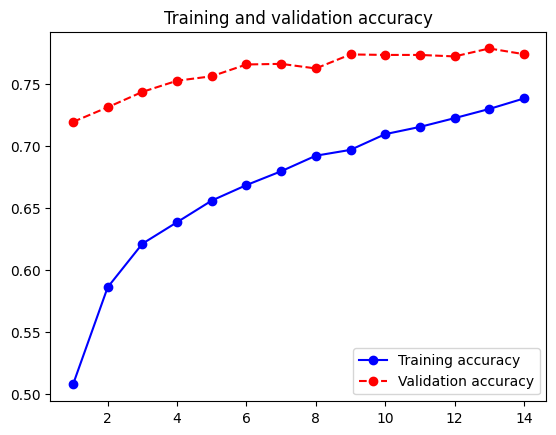

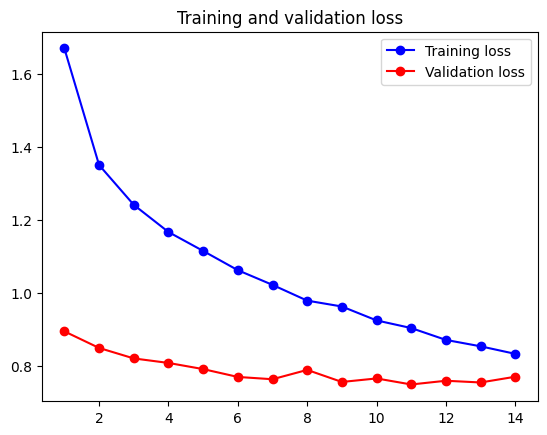

In [ ]:
from utils import plot

plot(history)

313/313 - 27s - 87ms/step - accuracy: 0.7665 - loss: 0.7782
Test accuracy: 76.65%
Test loss: 0.7782
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 92ms/step


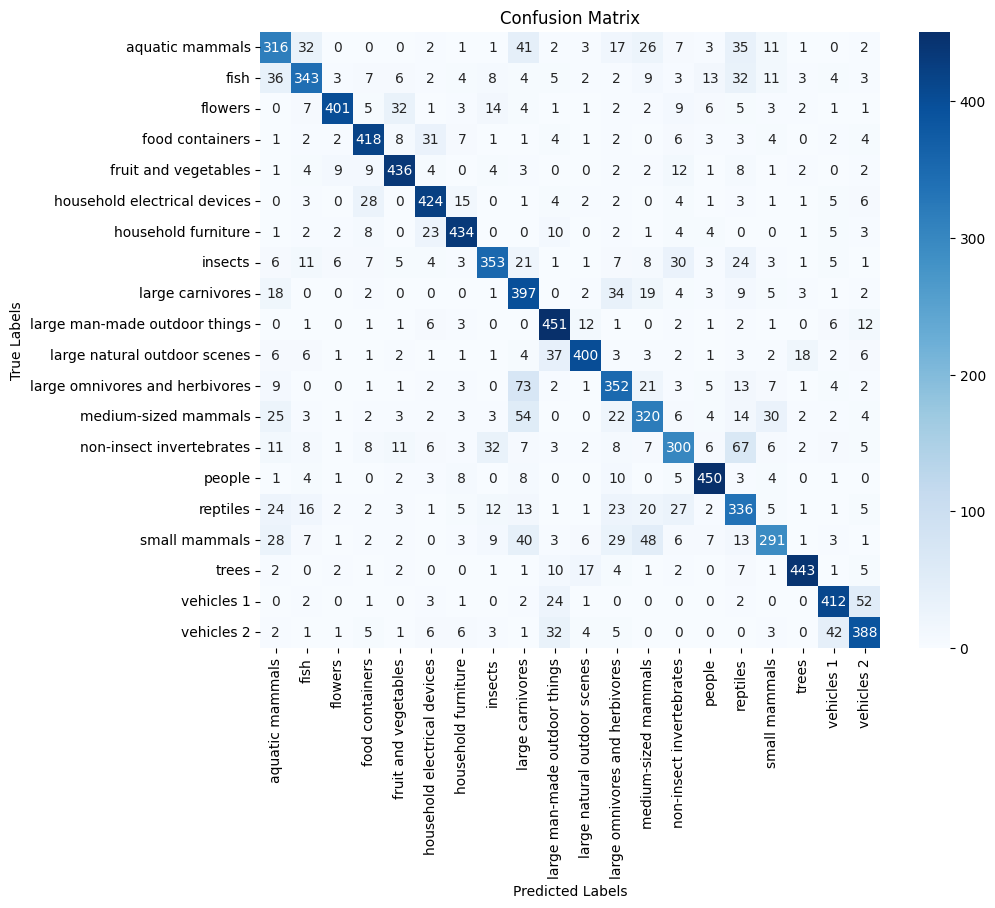

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model_resnet_fe.evaluate(x_test, y_test, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Predict the classes for the test set
y_pred = model_resnet_fe.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define the category names
category_names = [
    "aquatic mammals",
    "fish",
    "flowers",
    "food containers",
    "fruit and vegetables",
    "household electrical devices",
    "household furniture",
    "insects",
    "large carnivores",
    "large man-made outdoor things",
    "large natural outdoor scenes",
    "large omnivores and herbivores",
    "medium-sized mammals",
    "non-insect invertebrates",
    "people",
    "reptiles",
    "small mammals",
    "trees",
    "vehicles 1",
    "vehicles 2"
]

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### EfficientNetB0

In [ ]:

conv_base_efficient = keras.applications.EfficientNetB0(include_top = False,
                                        weights = 'imagenet',
                                        input_shape= (224, 224,3))
conv_base_efficient.trainable = False
#conv_base_efficient.summary()


In [ ]:
data_augmentation = keras.Sequential(
    [

        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.Resizing(height=224, width=224, interpolation= "nearest")(x)
x = keras.applications.efficientnet.preprocess_input(x) # pass throught function
x = conv_base_efficient(x)
x = layers.Flatten()(x)
x= layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Dropout para combatir el overfitting
outputs = layers.Dense(20, activation="softmax")(x)
model_efficient_fe = keras.Model(inputs, outputs)
model_efficient_fe.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/efficientnet_fe.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True)
]
history = model_efficient_fe.fit(
    x_train, y_train,
    epochs=60,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    batch_size=64)

Epoch 1/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 206ms/step - accuracy: 0.2635 - loss: 2.5069 - val_accuracy: 0.5042 - val_loss: 1.5841
Epoch 2/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 200ms/step - accuracy: 0.3970 - loss: 1.9393 - val_accuracy: 0.5360 - val_loss: 1.4703
Epoch 3/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 200ms/step - accuracy: 0.4354 - loss: 1.8175 - val_accuracy: 0.5577 - val_loss: 1.3996
Epoch 4/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 199ms/step - accuracy: 0.4513 - loss: 1.7637 - val_accuracy: 0.5682 - val_loss: 1.3673
Epoch 5/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 199ms/step - accuracy: 0.4604 - loss: 1.7129 - val_accuracy: 0.5719 - val_loss: 1.3343
Epoch 6/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 199ms/step - accuracy: 0.4781 - loss: 1.6711 - val_accuracy: 0.5939 - val_loss: 1.2834
Epoch 7/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 199ms/step - accuracy: 0.4818 - loss: 1.6475 - val_accuracy: 0.5945 - val_loss: 1.2646
Epoch 8/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 199ms/step - accuracy: 0.4903 -

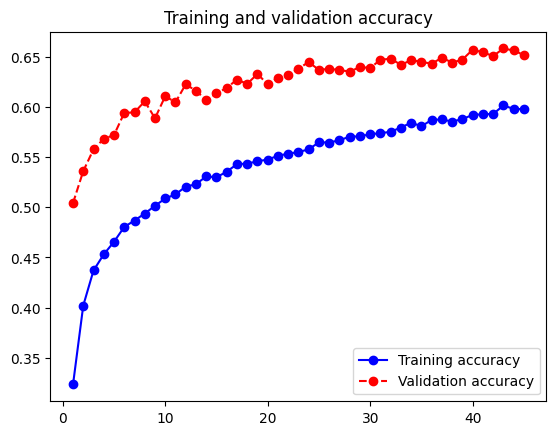

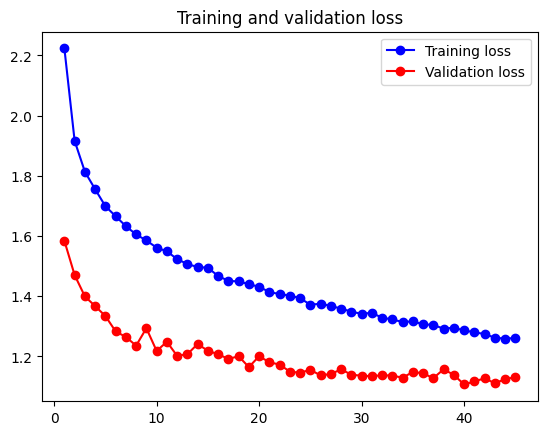

In [ ]:
plot(history)

313/313 - 21s - 66ms/step - accuracy: 0.6536 - loss: 1.1182
Test accuracy: 65.36%
Test loss: 1.1182
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step


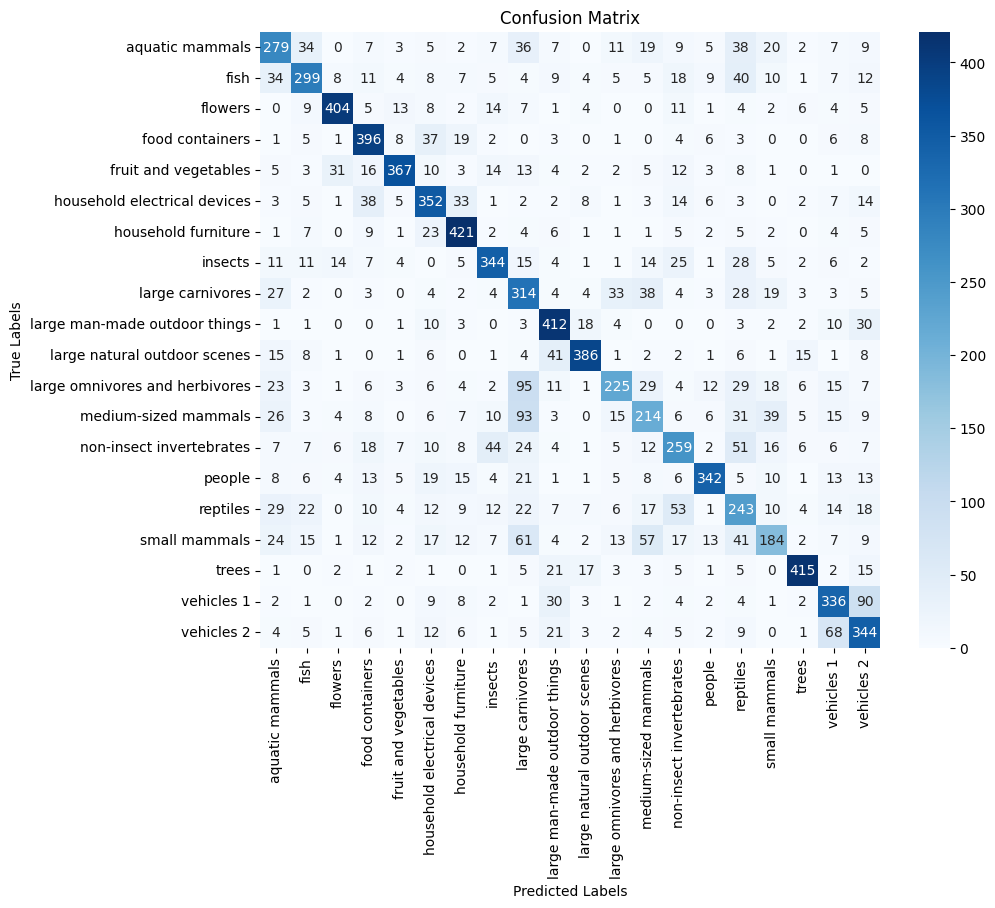

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model_efficient_fe.evaluate(x_test, y_test, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Predict the classes for the test set
y_pred = model_efficient_fe.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Fine Tuning

For Fine Tuning, the pretrained base is set to trainable, but we freeze most of the early layers. Specifically, all layers except the last 27 in ResNet50V2 and the last 25 in EfficientNetB0 are frozen. This allows the higher-level features to be fine-tuned for the CIFAR100 dataset while preserving the general representations learned on ImageNet.

### ResNet50V2

In [ ]:
conv_base_resnet = keras.applications.ResNet50V2(include_top = False,
                                        weights = 'imagenet',
                                        input_shape= (224,224,3))

conv_base_resnet.trainable = True

for layer in conv_base_resnet.layers[:-27]:
    layer.trainable = False

conv_base_resnet.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 12,083,200 (46.09 MB)

 Non-trainable params: 11,481,600 (43.80 MB)

In [ ]:
data_augmentation = keras.Sequential(
    [

        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.Resizing(height=224, width=224, interpolation= "nearest")(x)
x  = keras.applications.resnet_v2.preprocess_input(x)
x = conv_base_resnet(x)
x = layers.Flatten()(x)
x= layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Dropout para combatir el overfitting
outputs = layers.Dense(20, activation='softmax')(x)
model_resnet_ft = keras.Model(inputs, outputs)
model_resnet_ft.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/resnet_ft.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True)
]
history = model_resnet_ft.fit(
    x_train, y_train,
    epochs=60,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    batch_size=64)

Epoch 1/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 217s 321ms/step - accuracy: 0.5014 - loss: 1.7711 - val_accuracy: 0.7884 - val_loss: 0.6860
Epoch 2/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 316ms/step - accuracy: 0.7081 - loss: 0.9342 - val_accuracy: 0.8053 - val_loss: 0.6075
Epoch 3/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 316ms/step - accuracy: 0.7646 - loss: 0.7464 - val_accuracy: 0.8165 - val_loss: 0.5837
Epoch 4/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 317ms/step - accuracy: 0.7974 - loss: 0.6327 - val_accuracy: 0.8334 - val_loss: 0.5491
Epoch 5/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 317ms/step - accuracy: 0.8254 - loss: 0.5473 - val_accuracy: 0.8349 - val_loss: 0.5486
Epoch 6/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 194s 311ms/step - accuracy: 0.8431 - loss: 0.4888 - val_accuracy: 0.8367 - val_loss: 0.5596
Epoch 7/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 316ms/step - accuracy: 0.8590 - loss: 0.4355 - val_accuracy: 0.8451 - val_loss: 0.5286
Epoch 8/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 194s 311ms/step - accuracy: 0.8760 -

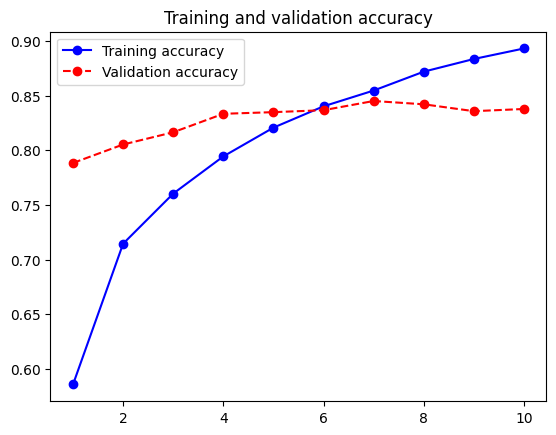

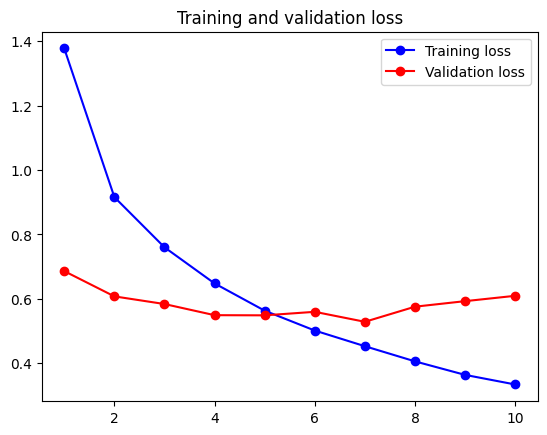

In [ ]:
plot(history)

313/313 - 27s - 86ms/step - accuracy: 0.8322 - loss: 0.5758
Test accuracy: 83.22%
Test loss: 0.5758
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 92ms/step


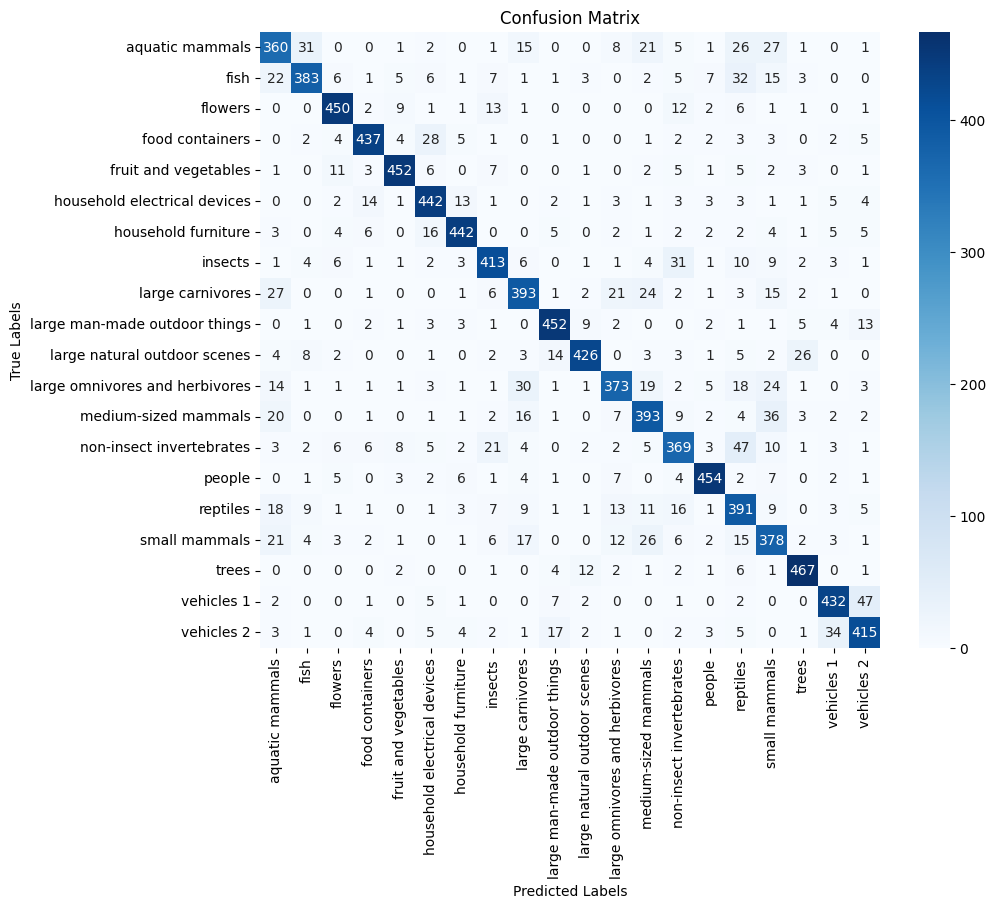

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model_resnet_ft.evaluate(x_test, y_test, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Predict the classes for the test set
y_pred = model_resnet_ft.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### EfficientNetB0

In [ ]:
import keras

conv_base_efficient = keras.applications.EfficientNetB0(include_top = False,
                                        weights = 'imagenet',
                                        input_shape= (224,224,3))
conv_base_efficient.trainable = True

for layer in conv_base_efficient.layers[:-25]:
    layer.trainable = False

conv_base_efficient.summary()

I0000 00:00:1742395137.623098    6384 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4233 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 1,462,752 (5.58 MB)

 Non-trainable params: 2,586,819 (9.87 MB)

In [ ]:
from keras import  layers
data_augmentation = keras.Sequential(
    [

        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.Resizing(height=224, width=224, interpolation= "nearest")(x)
x = keras.applications.efficientnet.preprocess_input(x)
x = conv_base_efficient(x)
x = layers.Flatten()(x)
x= layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(20, activation='softmax')(x)
model_efficient_ft = keras.Model(inputs, outputs)
model_efficient_ft.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/efficient_ft.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True)
]
history = model_efficient_ft.fit(
    x_train, y_train,
    epochs=60,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    batch_size=32)

Epoch 1/60


E0000 00:00:1742395195.539197    6384 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1742395200.448840    7167 cuda_dnn.cc:529] Loaded cuDNN version 90300


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 95ms/step - accuracy: 0.3484 - loss: 2.2181 - val_accuracy: 0.6125 - val_loss: 1.2639
Epoch 2/60
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 116s 93ms/step - accuracy: 0.5254 - loss: 1.5268 - val_accuracy: 0.6472 - val_loss: 1.1459
Epoch 3/60
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 131s 105ms/step - accuracy: 0.5710 - loss: 1.3811 - val_accuracy: 0.6766 - val_loss: 1.0334
Epoch 4/60
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 90ms/step - accuracy: 0.6114 - loss: 1.2529 - val_accuracy: 0.6830 - val_loss: 1.0303
Epoch 5/60
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 111s 89ms/step - accuracy: 0.6343 - loss: 1.1662 - val_accuracy: 0.6991 - val_loss: 1.0031
Epoch 6/60
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 111s 89ms/step - accuracy: 0.6603 - loss: 1.0832 - val_accuracy: 0.7041 - val_loss: 0.9929
Epoch 7/60
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 89ms/step - accuracy: 0.6746 - loss: 1.0359 - val_accuracy: 0.7039 - val_loss: 0.9916
Epoch 8/60
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 111s 89ms/step - accuracy: 0.6840 - l

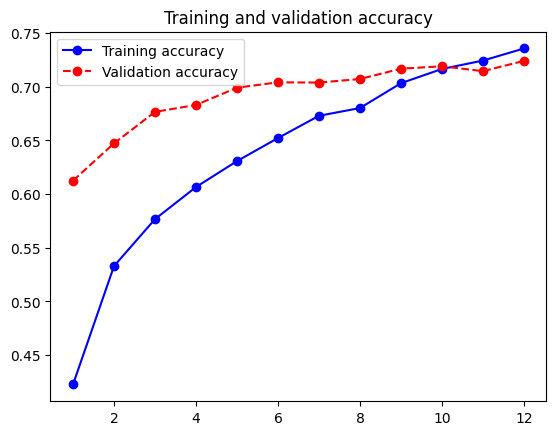

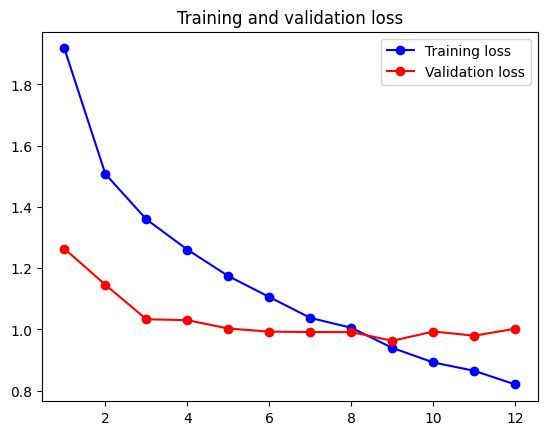

In [ ]:
from utils import plot
plot(history)

313/313 - 17s - 53ms/step - accuracy: 0.7129 - loss: 0.9625
Test accuracy: 71.29%
Test loss: 0.9625
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step


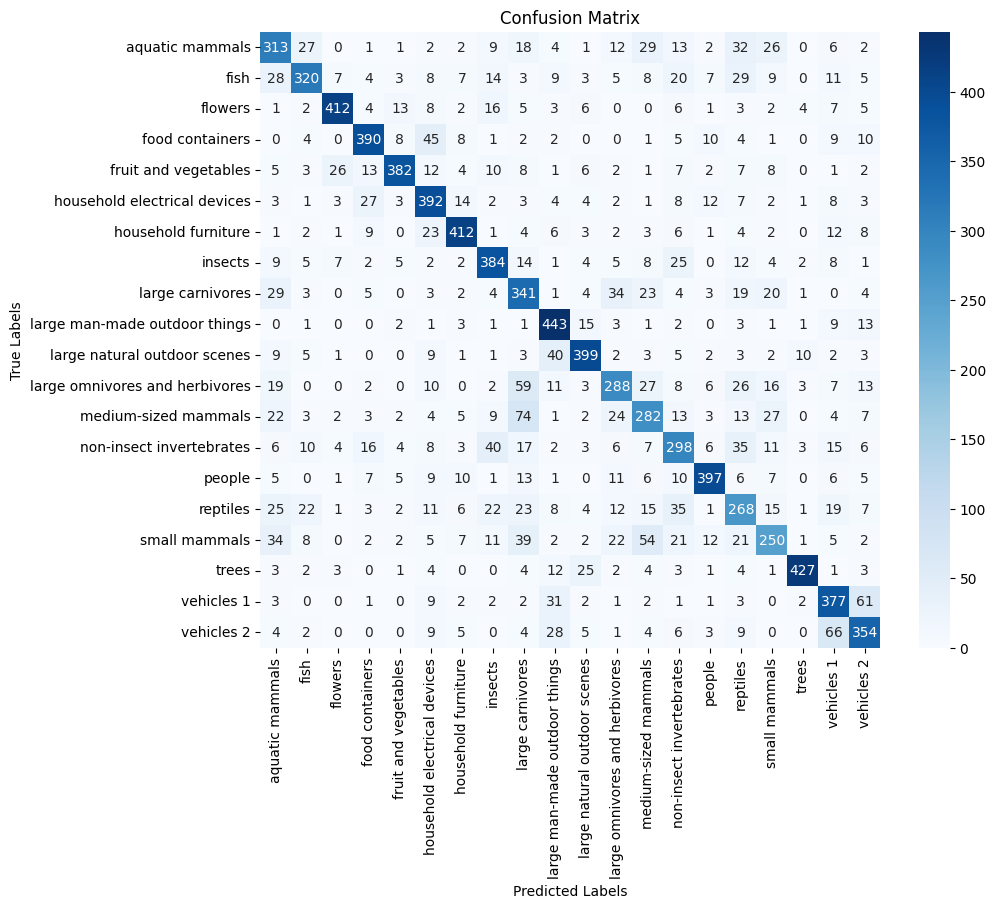

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model_efficient_ft.evaluate(x_test, y_test, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Predict the classes for the test set
y_pred = model_efficient_ft.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

category_names = [
    "aquatic mammals",
    "fish",
    "flowers",
    "food containers",
    "fruit and vegetables",
    "household electrical devices",
    "household furniture",
    "insects",
    "large carnivores",
    "large man-made outdoor things",
    "large natural outdoor scenes",
    "large omnivores and herbivores",
    "medium-sized mammals",
    "non-insect invertebrates",
    "people",
    "reptiles",
    "small mammals",
    "trees",
    "vehicles 1",
    "vehicles 2"
]

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **Discussion**

Below is a summary of the test accuracy for each model and strategy:

| **Model**         | **Strategy**          | **Test Accuracy** | **Observations**                                                  |
|-------------------|-----------------------|-------------------|--------------------------------------------------------------------|
| **ResNet50V2**    | Feature Extraction    | 76.65%           | Good initial performance.                                          |
| **EfficientNetB0**| Feature Extraction    | 65.36%           | Slightly lower, possibly due to architectural constraints.         |
| **ResNet50V2**    | Fine-Tuning           | 83.22%           | Significant improvement, showing better adaptation.                |
| **EfficientNetB0**| Fine-Tuning           | 71.29%           | Improved from FE, though still below ResNet50V2 FT.                |

Our experiments with pretrained models on the CIFAR100 dataset provide important insights into the impact of different training strategies. We compared two approaches—Feature Extraction (FE) and Fine Tuning (FT)—using ResNet50V2 and EfficientNetB0 as our base architectures. The results indicate that allowing the network to adjust its high-level features through fine tuning can lead to better performance compared to keeping the pretrained features fixed via feature extraction.

In the Feature Extraction approach, the weights of the pretrained base are frozen, and only the newly added classifier layers are trained. This method is computationally efficient and minimizes the risk of overfitting due to the lower number of trainable parameters. However, the fixed features extracted from ImageNet may not be optimally suited for the specific characteristics of the CIFAR100 images. In contrast, Fine Tuning involves unfreezing a portion of the base model—typically the later layers—so that the network can adapt its representations to the new domain. Our findings show that fine tuning improves accuracy significantly; for example, ResNet50V2 improved from around 76.65% to 83.22% when fine tuned, and EfficientNetB0 increased its performance from approximately 65.36% to 71.29%.

Moreover, comparing the two architectures, ResNet50V2 consistently outperforms EfficientNetB0 under both training strategies. This may be due to the deeper and more robust nature of ResNet50V2, which likely learns more discriminative features that generalize better to the variations present in CIFAR100. EfficientNetB0, although efficient and lightweight, appears to be less capable in capturing the detailed patterns necessary for this task, as reflected in its lower accuracy.


## Advantages and Disadvantages

- **Feature Extraction (FE)**  
  - **Advantages**: Faster training (fewer trainable parameters), lower risk of overfitting.  
  - **Disadvantages**: Might not achieve maximum possible accuracy because the pretrained features remain fixed.

- **Fine-Tuning (FT)**  
  - **Advantages**: Adapts the high-level features to the specifics of CIFAR100, often leading to higher accuracy.  
  - **Disadvantages**: More training time, higher risk of overfitting if too many layers are unfrozen or if the learning rate is too high.


# **Conclusion**

In summary, our experiments demonstrate that adapting the pretrained models to the CIFAR100 domain through fine tuning leads to noticeably better performance compared to using fixed features. Fine tuning enables the models—especially ResNet50V2—to adjust their higher-level representations to capture more specific patterns present in CIFAR100. Although feature extraction offers a simpler and computationally efficient alternative, it appears insufficient to fully leverage the capacity of the pretrained architectures for this task. These findings highlight the need to tailor the training strategy to the target dataset and suggest that further exploration of hyperparameter optimization may yield even better results.